In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/advanced-dls-spring-2021/submission.csv
/kaggle/input/advanced-dls-spring-2021/train.csv
/kaggle/input/advanced-dls-spring-2021/test.csv


#  Первая часть. Исследование

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

# Загрузка данных

In [ ]:
train = pd.read_csv('/kaggle/input/advanced-dls-spring-2021/train.csv')
test = pd.read_csv('/kaggle/input/advanced-dls-spring-2021/test.csv')

In [ ]:
train.sample(5) # посмотрим случайные 5 строк

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
739,58,100.35,5681.1,Male,0,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,One year,No,Credit card (automatic),0
2612,41,78.45,3126.45,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,No,Yes,Yes,Yes,Two year,No,Electronic check,0
3823,53,93.90,5029.2,Male,0,Yes,No,Yes,Yes,Fiber optic,Yes,No,Yes,No,No,Yes,Month-to-month,No,Electronic check,1
4764,23,24.35,538.5,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1619,38,83.45,3147.15,Female,1,Yes,No,Yes,No,Fiber optic,Yes,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,0


In [ ]:
train.shape, test.shape # посмотрим размер (строки, столбцы)

((5282, 20), (1761, 19))

In [ ]:
# Для вашего удобства списки с именами разных колонок

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [ ]:
# Посмотрим на типы данных
train.dtypes, test.dtypes

(ClientPeriod                  int64
 MonthlySpending             float64
 TotalSpent                   object
 Sex                          object
 IsSeniorCitizen               int64
 HasPartner                   object
 HasChild                     object
 HasPhoneService              object
 HasMultiplePhoneNumbers      object
 HasInternetService           object
 HasOnlineSecurityService     object
 HasOnlineBackup              object
 HasDeviceProtection          object
 HasTechSupportAccess         object
 HasOnlineTV                  object
 HasMovieSubscription         object
 HasContractPhone             object
 IsBillingPaperless           object
 PaymentMethod                object
 Churn                         int64
 dtype: object,
 ClientPeriod                  int64
 MonthlySpending             float64
 TotalSpent                   object
 Sex                          object
 IsSeniorCitizen               int64
 HasPartner                   object
 HasChild             

In [ ]:
# Проверьте наличие NaN во всем DataFrame
train.isnull().values.any(), test.isnull().values.any()

(False, False)

In [ ]:
(train.isna() | train.isnull()).sum()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

In [ ]:
(test.isna() | test.isnull()).sum()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
dtype: int64

In [ ]:
# Проверим пропущенные строки
train.applymap(lambda x: x == ' ').sum(), test.applymap(lambda x: x == ' ').sum()

(ClientPeriod                0
 MonthlySpending             0
 TotalSpent                  9
 Sex                         0
 IsSeniorCitizen             0
 HasPartner                  0
 HasChild                    0
 HasPhoneService             0
 HasMultiplePhoneNumbers     0
 HasInternetService          0
 HasOnlineSecurityService    0
 HasOnlineBackup             0
 HasDeviceProtection         0
 HasTechSupportAccess        0
 HasOnlineTV                 0
 HasMovieSubscription        0
 HasContractPhone            0
 IsBillingPaperless          0
 PaymentMethod               0
 Churn                       0
 dtype: int64,
 ClientPeriod                0
 MonthlySpending             0
 TotalSpent                  2
 Sex                         0
 IsSeniorCitizen             0
 HasPartner                  0
 HasChild                    0
 HasPhoneService             0
 HasMultiplePhoneNumbers     0
 HasInternetService          0
 HasOnlineSecurityService    0
 HasOnlineBackup        

В столбце TotalSpent есть пропуски, исправим

In [ ]:
(train.TotalSpent == ' ').sum(), (test.TotalSpent == ' ').sum()

(9, 2)

Конвертируем колонку  TotalSpent и  заполним пропущенные значения

In [ ]:
total_spent = pd.to_numeric(train.TotalSpent, errors='coerce')
train.TotalSpent = total_spent.fillna(0) # total_spent.mean()
total_spent = pd.to_numeric(test.TotalSpent, errors='coerce')
test.TotalSpent = total_spent.fillna(0)

# Анализ данных

In [ ]:
# Числовые признаки
num_cols

['ClientPeriod', 'MonthlySpending', 'TotalSpent']

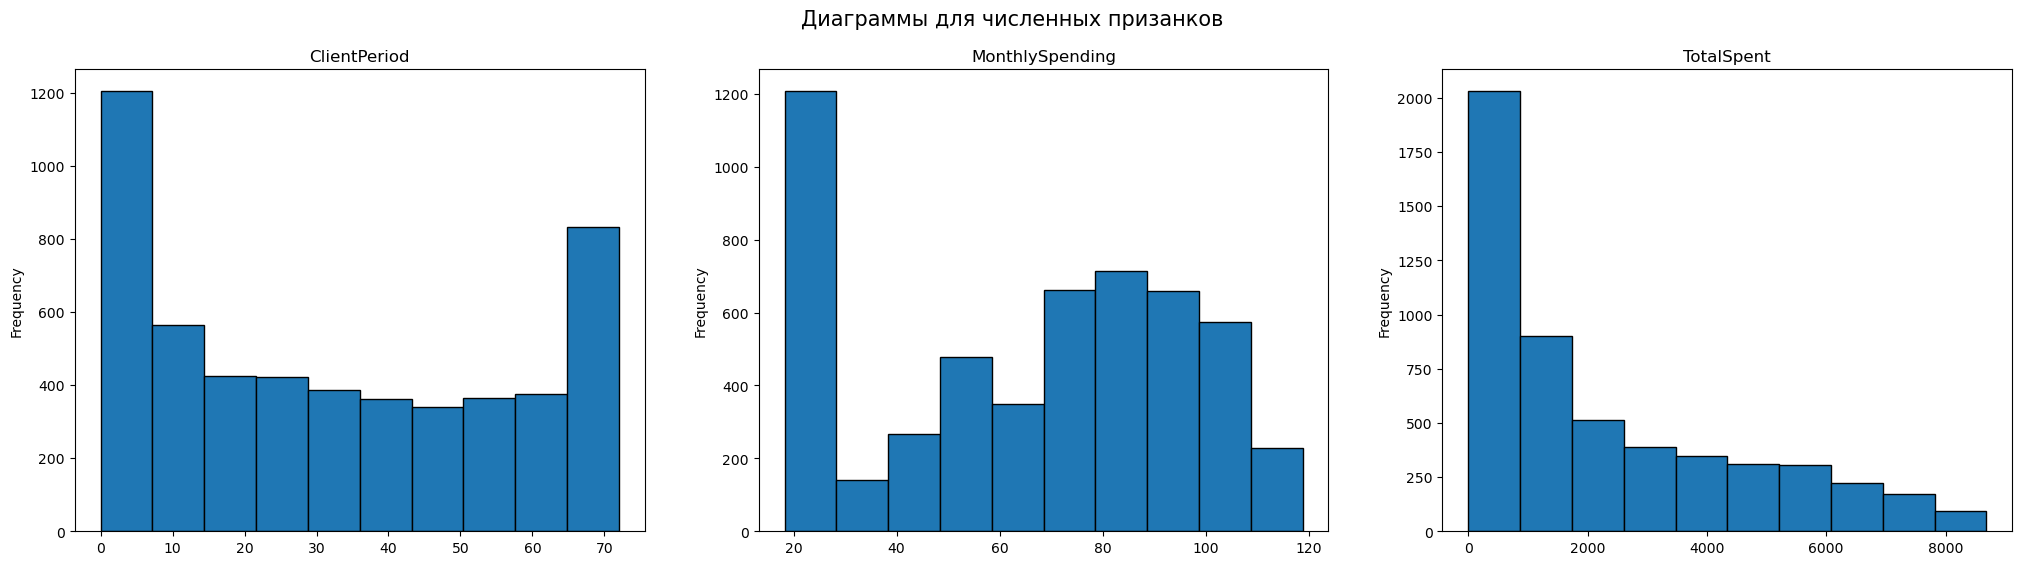

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(25, 6))
fig.suptitle('Диаграммы для численных призанков', fontsize=15)
for ax, col in zip(axes.flatten(), train[num_cols].columns):
  ax.set_title(col)
  train[col].plot(kind="hist", ec="black", ax=ax)

In [ ]:
# Категориальные  признаки
cat_cols

['Sex',
 'IsSeniorCitizen',
 'HasPartner',
 'HasChild',
 'HasPhoneService',
 'HasMultiplePhoneNumbers',
 'HasInternetService',
 'HasOnlineSecurityService',
 'HasOnlineBackup',
 'HasDeviceProtection',
 'HasTechSupportAccess',
 'HasOnlineTV',
 'HasMovieSubscription',
 'HasContractPhone',
 'IsBillingPaperless',
 'PaymentMethod']

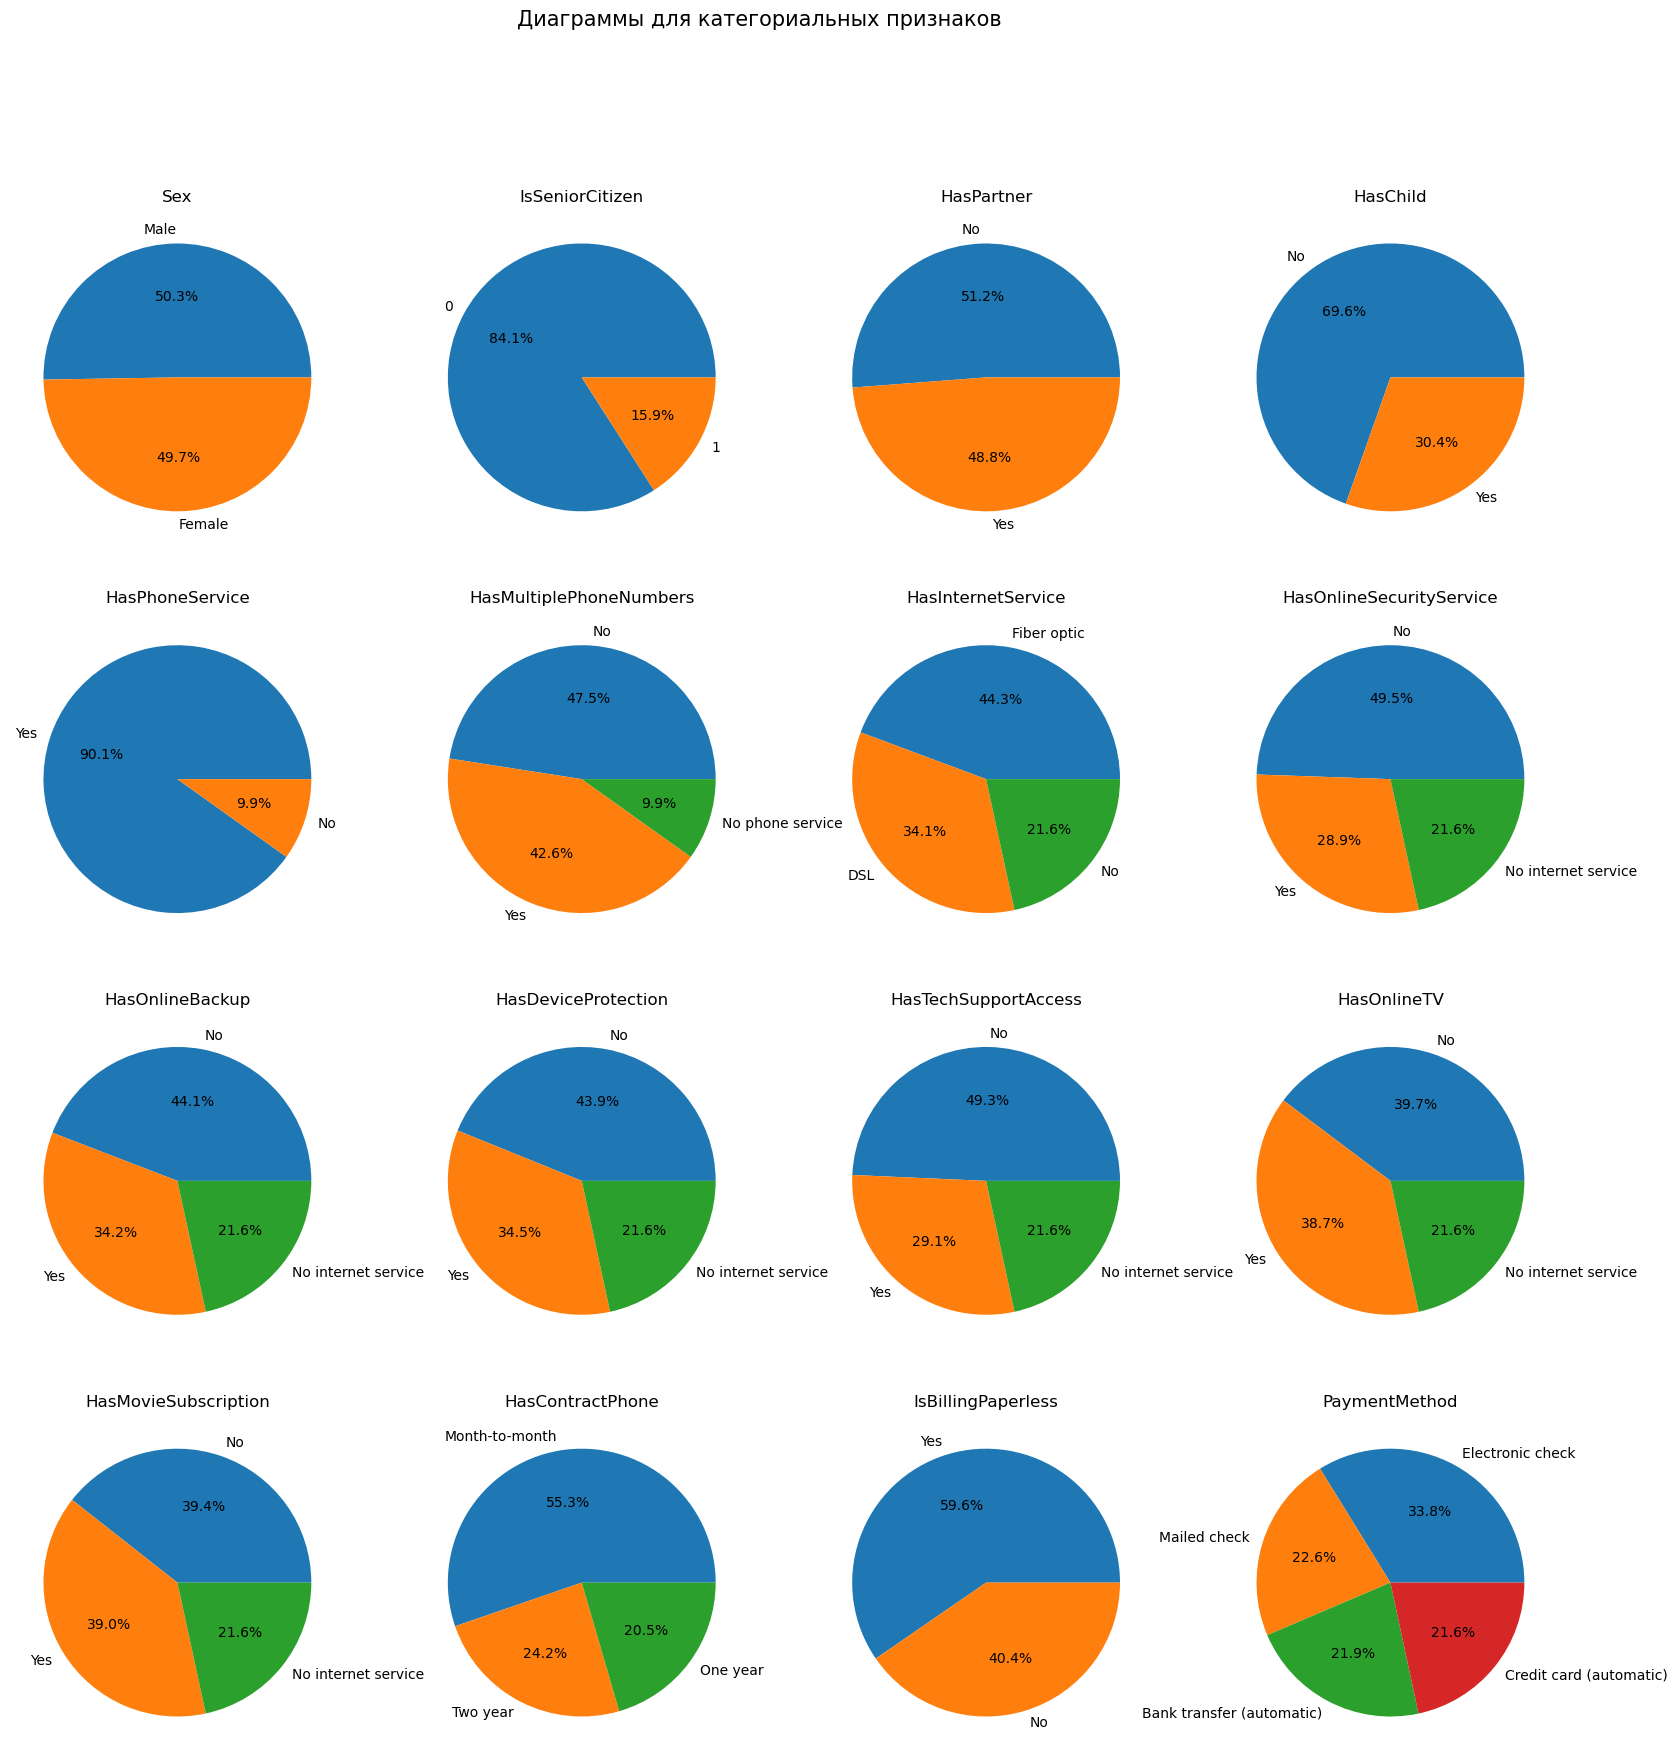

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
fig.suptitle('Диаграммы для категориальных признаков', fontsize=15)
for ax, col in zip(axes.flatten(), train[cat_cols].columns):
  ax.set_title(col)
  ax.pie(train[col].value_counts(), autopct="%1.1f%%", labels=train[col].value_counts().index)

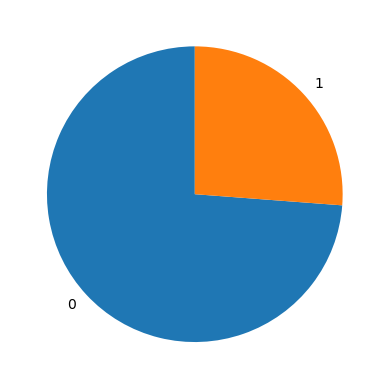

In [ ]:
target = train[target_col].value_counts()
plt.pie(
    target,
    labels=list(target.index),
    startangle = 90
)
plt.show()

Сильно несбалансированных классов нет. Классы слегка разбалансированы, т.к. ушедших абонентов("Churn" = 0) примерно в три раза меньше, чем остающихся("Churn" = 1). Но в данном случае не надо применять специальные методы обработки, которые требуются в случае сильного дисбаланса.
В данном наборе данных нет ярко выраженного дисбаланса классов

# Применение линейных моделей

In [ ]:
train_x = train.drop(target_col, axis=1)
train_y = train[target_col]

Применим one-hot-encoding к категориальным признакам и отнормируем числовые:

StandardScaler (стандартный масштабатор) используется для изменения размера распределения значений так, чтобы среднее значение наблюдаемых значений было равно 0, а стандартное отклонение – 1. (μ = 0, σ = 1).

OneHotEncoder - этот кодировщик берёт столбец с категориальными данными, который был предварительно закодирован в признак, и создаёт для него несколько новых столбцов. Числа заменяются на единицы и нули, в зависимости от того, какому столбцу какое значение присуще.

In [ ]:
data_norm = ColumnTransformer([
        ('num_cols', StandardScaler(), num_cols),
        ('cat_cols', OneHotEncoder(), cat_cols)
    ])

make_pipeline — это сокращение для построения конвейеров; он принимает переменное количество оценщиков и возвращает конвейер, автоматически заполняя имена

Найдем лучшие значения гиперпараметра С

In [ ]:
pipeline = make_pipeline(data_norm, LogisticRegression())

In [ ]:
param_grid = {
    'logisticregression__C': [100, 10, 1, 0.1, 0.01, 0.001],
    'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'logisticregression__max_iter': [500, 1000]
}

gs = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='roc_auc', refit=True, n_jobs=-1)
gs.fit(train_x, train_y)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num_cols',
                                                                         StandardScaler(),
                                                                         ['ClientPeriod',
                                                                          'MonthlySpending',
                                                                          'TotalSpent']),
                                                                        ('cat_cols',
                                                                         OneHotEncoder(),
                                                                         ['Sex',
                                                                          'IsSeniorCitizen',
                                                                          'HasPartner',
                                                     

Видим, что модель дает следующие лучшие параметры

In [ ]:
gs.best_score_

0.845120409200234

In [ ]:
gs.best_params_

{'logisticregression__C': 100,
 'logisticregression__max_iter': 1000,
 'logisticregression__solver': 'saga'}

# Применение градиентного бустинга

Разделим выборку на train/valid. Протестируем catboost cо стандартными параметрами.

In [ ]:
x = train.drop(target_col, axis=1)
y = train[target_col]
train_x, valid_x, train_y, valid_y = train_test_split(x, y, train_size=0.8, random_state=23)

Протестируем catboost cо стандартными параметрами

In [ ]:
catbst_default = CatBoostClassifier(
    cat_features=cat_cols,
    eval_metric='AUC',
)

catbst_default.fit(
    train_x, train_y,
    cat_features=cat_cols,
    eval_set=(valid_x, valid_y),
    verbose = 100
)

Learning rate set to 0.045236
0:	test: 0.8122493	best: 0.8122493 (0)	total: 15.6ms	remaining: 15.6s
100:	test: 0.8606407	best: 0.8608711 (73)	total: 1.18s	remaining: 10.5s
200:	test: 0.8617095	best: 0.8617144 (195)	total: 2.23s	remaining: 8.85s
300:	test: 0.8611433	best: 0.8622047 (227)	total: 3.41s	remaining: 7.91s
400:	test: 0.8589811	best: 0.8622047 (227)	total: 4.6s	remaining: 6.87s
500:	test: 0.8581059	best: 0.8622047 (227)	total: 5.8s	remaining: 5.78s
600:	test: 0.8571597	best: 0.8622047 (227)	total: 7s	remaining: 4.64s
700:	test: 0.8554535	best: 0.8622047 (227)	total: 8.16s	remaining: 3.48s
800:	test: 0.8530413	best: 0.8622047 (227)	total: 9.36s	remaining: 2.33s
900:	test: 0.8525461	best: 0.8622047 (227)	total: 10.6s	remaining: 1.16s
999:	test: 0.8507663	best: 0.8622047 (227)	total: 11.8s	remaining: 0us

bestTest = 0.8622047244
bestIteration = 227

Shrink model to first 228 iterations.


In [ ]:
roc_auc_score(valid_y, catbst_default.predict_proba(valid_x)[:,-1])

0.8622047244094488

CatBoost выдал лучшее качество по сравнению с логистической регрессией

Протестировав разные значения параметроа количества деревьев и learning_rate'а и выбрали лучшую по метрике ROC-AUC комбинацию:

In [ ]:
model_boost = CatBoostClassifier(n_estimators=200,
                                cat_features=cat_cols,
                                eval_metric='AUC',
                                random_seed=42,
                                learning_rate=0.2,
                                l2_leaf_reg = 1.19,
                                depth = 5 #глубина дерева
                                )

model_boost.fit(train_x, train_y,
              cat_features=cat_cols,
              use_best_model=True,
              eval_set=(valid_x, valid_y),
              verbose = 50
              )

0:	test: 0.8321991	best: 0.8321991 (0)	total: 10.9ms	remaining: 2.18s
50:	test: 0.8651587	best: 0.8651979 (49)	total: 468ms	remaining: 1.37s
100:	test: 0.8647616	best: 0.8669728 (62)	total: 960ms	remaining: 941ms
150:	test: 0.8608197	best: 0.8669728 (62)	total: 1.45s	remaining: 469ms
199:	test: 0.8546666	best: 0.8669728 (62)	total: 1.93s	remaining: 0us

bestTest = 0.8669727694
bestIteration = 62

Shrink model to first 63 iterations.


Лучшее качество при learning_rate=0.2, n_estimators=200, depth = 5:

In [ ]:
roc_auc_score(valid_y, model_boost.predict_proba(valid_x)[:,-1])

0.8669727694374443

# Предсказания

In [ ]:
best_model = model_boost

In [ ]:
submission = pd.read_csv('../input/advanced-dls-spring-2021/submission.csv', index_col='Id')

In [ ]:
submission['Churn'] = best_model.predict_proba(test)[:, 1]
submission.to_csv('./my_submission.csv')


In [ ]:
submission

,Churn
Id,
0,0.026678
1,0.682656
2,0.659953
3,0.010168
4,0.004010
...,...
1756,0.117411
1757,0.007503
1758,0.823132


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter